In [185]:
%matplotlib widget

from sklearn.datasets import load_iris
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [186]:
# load the full dataset and display it
dataset = load_iris()
names = dataset.feature_names
data = dataset.data
target = dataset.target

print(names)
print(data.dtype, data)
print(target.dtype, target)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
float64 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.

In [187]:
# preprocess the data to remove the third category so we have binary classification for now
index = np.searchsorted(target, 2)

data = data[:index]
target = target[:index].astype(np.float64) # convert to float64

print(names)
print("Data: ", data.shape, data.dtype)
print("Target:", target.shape, target.dtype)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Data:  (100, 4) float64
Target: (100,) float64


Now we will use the logistic loss cost function instead of MSE. Hopefully, it will remove the odd local minima curves and make it clean like original MSE again.

In [188]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [189]:
def predict(w,b,x):
    prediction = np.matmul(x, w) + b
    
    return sigmoid(prediction) # pass it through a sigmoid

In [190]:
def log_loss_cost(w,b,x,y, epsilon=1e-15):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    
    prediction = sigmoid(np.matmul(x, w) + b) # mx1
    prediction = np.clip(prediction, epsilon, 1 - epsilon) # clip prediction to avoid overflow issues
    error = y * np.log(prediction) + (1 - y) * np.log(1 - prediction) # use logistic loss function
    error = error.reshape((-1)) # m
    
    return np.sum(error) / (-m)

In [191]:
def mse_cost(w,b,x,y):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    
    prediction = sigmoid(np.matmul(x, w) + b) # pass it through a sigmoid
    error = prediction - y
    error = error.reshape((-1)) # make it m (1d array) from mx1
    
    return np.dot(error, error) / (2*m)

In [192]:
def compute_loss_gradients(w,b,x,y):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features

    prediction = sigmoid(np.matmul(x, w) + b) # mx1
    error = prediction - y # mx1
    
    xT = np.transpose(x) # nxm
    dw = np.matmul(xT, error) / m # nx1
    db = np.sum(error) / m # 1

    return dw, db

In [193]:
def compute_mse_gradients(w,b,x,y):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features

    prediction = sigmoid(np.matmul(x, w) + b) # mx1
    predictionT = np.transpose(prediction) # 1xm

    error = (prediction - y) * prediction * (1 - prediction) # mx1

    xT = np.transpose(x) # nxm
    dw = np.matmul(xT, error) / m # nx1
    db = np.matmul(predictionT, (prediction - y) * (1 - prediction))[0,0] / m # 1

    return dw, db

Surprising thing here is that though the cost function changes, the gradient function is very identical to the old MSE. All we changed was we added a sigmoid to the prediction. 

In [194]:
def feature_scale(data_unscaled, scaled=True):
    if scaled == False:
        return data_unscaled

    mu = np.mean(data_unscaled, axis=0)
    std = np.std(data_unscaled, axis=0)

    data_scaled = np.array(data_unscaled)
    data_scaled = (data_scaled - mu) / std
    # z score normalization
    
    return data_scaled

data = feature_scale(data, scaled=True)

In [195]:
def show_cost_graph(costs, title, color):
    iterations = costs.shape[0]
    iteration_array = np.arange(0, iterations, dtype=np.int32)
    
    # graph the cost after updating the model
    fig, cost_graph = plt.subplots(layout='constrained')
    
    cost_graph.set_xlabel("Current Iteration")
    cost_graph.set_ylabel("Cost")
    
    cost_graph.set_title(title)
    
    cost_graph.plot(iteration_array, costs, color=color)

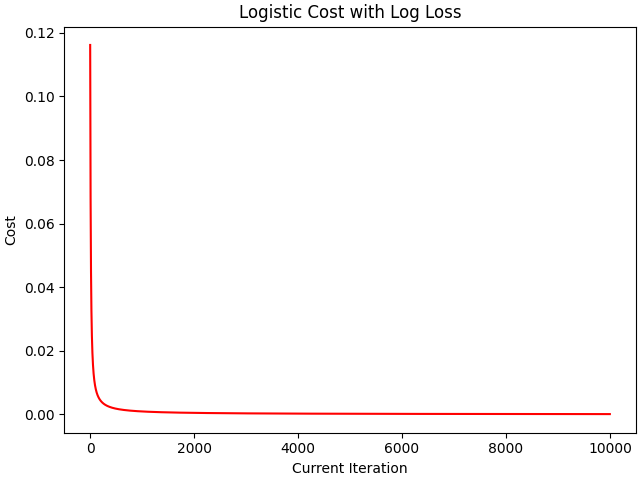

In [196]:
def gradient_descent(x, y, gradient_func, cost_func, learning_rate=0.01, max_iterations=1000):
    y = y.reshape((-1,1))
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    
    w = np.zeros((n,1)) # n features
    b = 0
    # initialize model parameters to zeroes
    
    costs = np.empty(0)

    for i in range(max_iterations):
        dw, db = gradient_func(w,b,x,y)
        
        w -= learning_rate * dw
        b -= learning_rate * db
        # update the weights
        
        current_cost = cost_func(w,b,x,y)
        costs = np.append(costs, current_cost)
        # add to array for visualization
    return w, b, costs
log_weights, log_intercept, log_costs = gradient_descent(data, target, compute_loss_gradients, log_loss_cost, learning_rate=0.2, max_iterations=10000)
mse_weights, mse_intercept, mse_costs = gradient_descent(data, target, compute_mse_gradients, mse_cost, learning_rate=0.2, max_iterations=10000)
show_cost_graph(mse_costs, title="Logistic Cost with Log Loss",color='r')

As we can see, the new cost function works and gradients are updating correctly. Let's look at how the cost curves change just like last time.

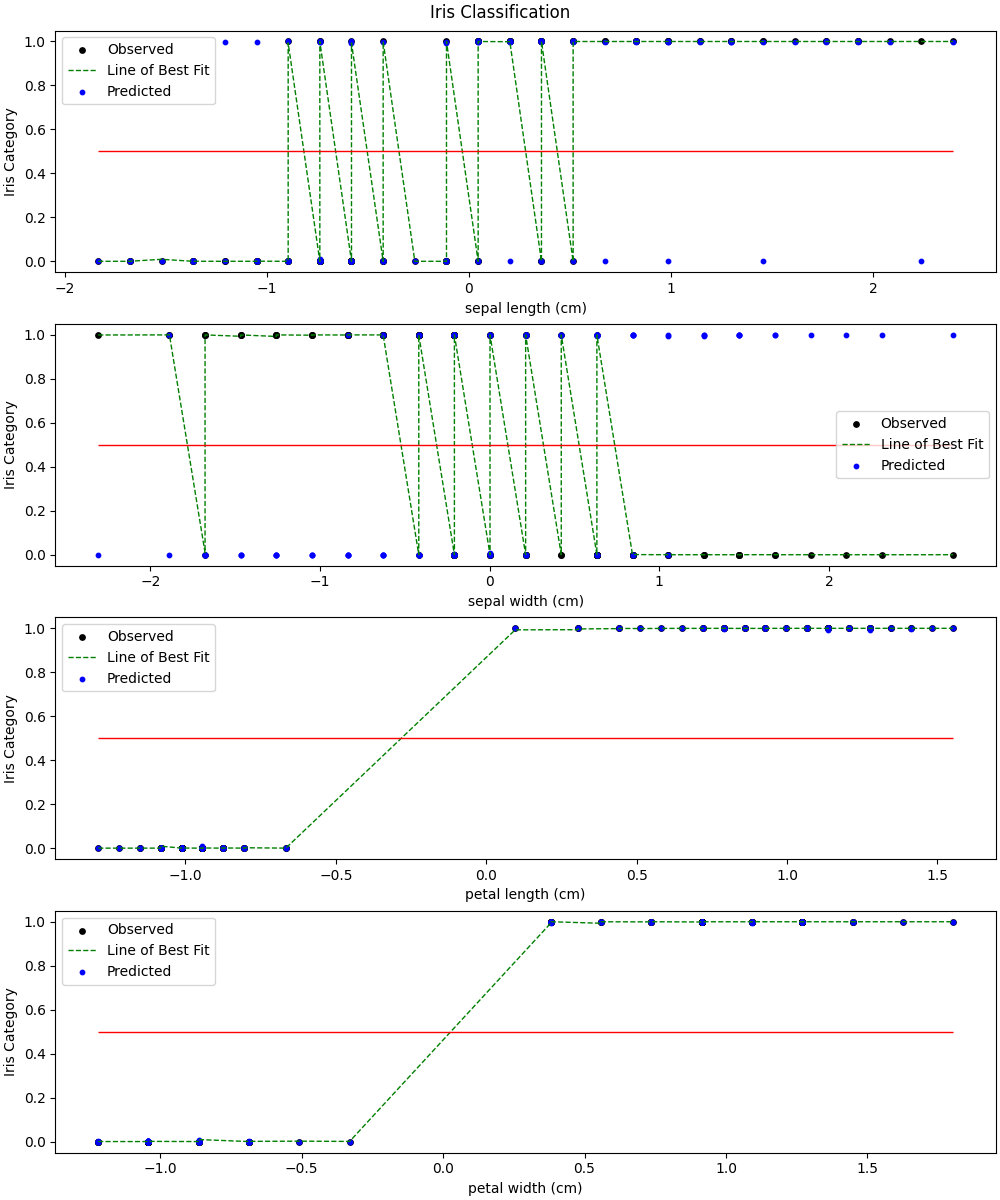

In [197]:
hypothesis_log = predict(log_weights, log_intercept, data).reshape(-1)
features = data.shape[1]

fig, axes = plt.subplots(features, layout="constrained",figsize=(10,12))
fig.suptitle("Iris Classification")
for i in range(features):
    axes[i].set_xlabel(names[i])
    axes[i].set_ylabel("Iris Category")

    idata, ipredict = zip(*sorted(zip(data[:,i], hypothesis_log))) # sort the x and y values and retrieve them
    
    axes[i].scatter(data[:,i], target, c="black",s=15,label="Observed")
    axes[i].plot(idata, ipredict, c="g", linewidth=1, linestyle='--',label="Line of Best Fit")
    axes[i].scatter(data[:,i], ipredict, c="blue",s=10,label="Predicted")
    axes[i].hlines(y=0.5, xmin=np.min(data[:,i]), xmax=np.max(data[:,i]), linewidth=1, color='r')
    axes[i].legend()

In [198]:
classify = np.round(hypothesis_log)
errors = np.sum(np.abs(classify - target))
print("Misclassifications:",errors)

Misclassifications: 0.0


No misclassifications like last time. Let's visualize how different intercept values affect the cost function. We'll fix all the other values and only change one of the values (intercept) with a range. This helps us visualize easier as well.

In [199]:
samples = 200
frange = 20
brange = np.linspace(-frange, frange, samples)

y_reshaped = target.reshape((-1,1))
msebcosts = np.empty(samples)
for i in range(samples):
    msebcosts[i] = mse_cost(mse_weights,brange[i],data,y_reshaped)

logbcosts = np.empty(samples)
for i in range(samples):
    logbcosts[i] = log_loss_cost(log_weights,brange[i],data,y_reshaped)

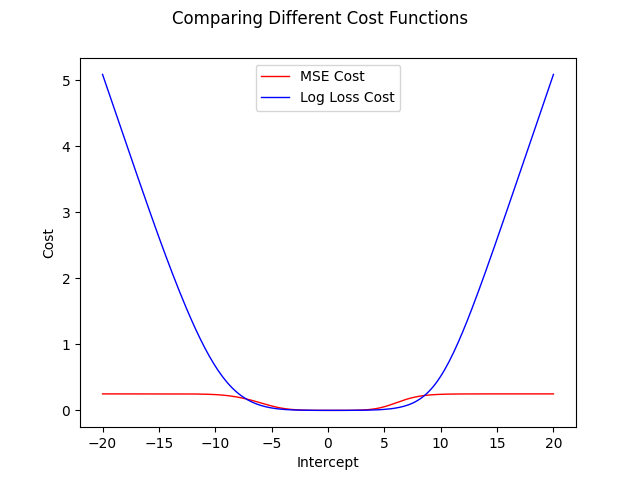

In [200]:
fig, ax = plt.subplots()
fig.suptitle("Comparing Different Cost Functions")
ax.plot(brange, msebcosts, c='r',linewidth=1,label="MSE Cost")
ax.plot(brange, logbcosts, c='b',linewidth=1,label="Log Loss Cost")
ax.set_xlabel("Intercept")
ax.set_ylabel("Cost")
ax.legend()

Cost Function looks a lot better now and only has one concavity as we wanted. Also, it doesn't become into a line the further we go off into distance like the MSE cost we examined. As before, let's look at all of the weights individually again while changing only one weight at a time.

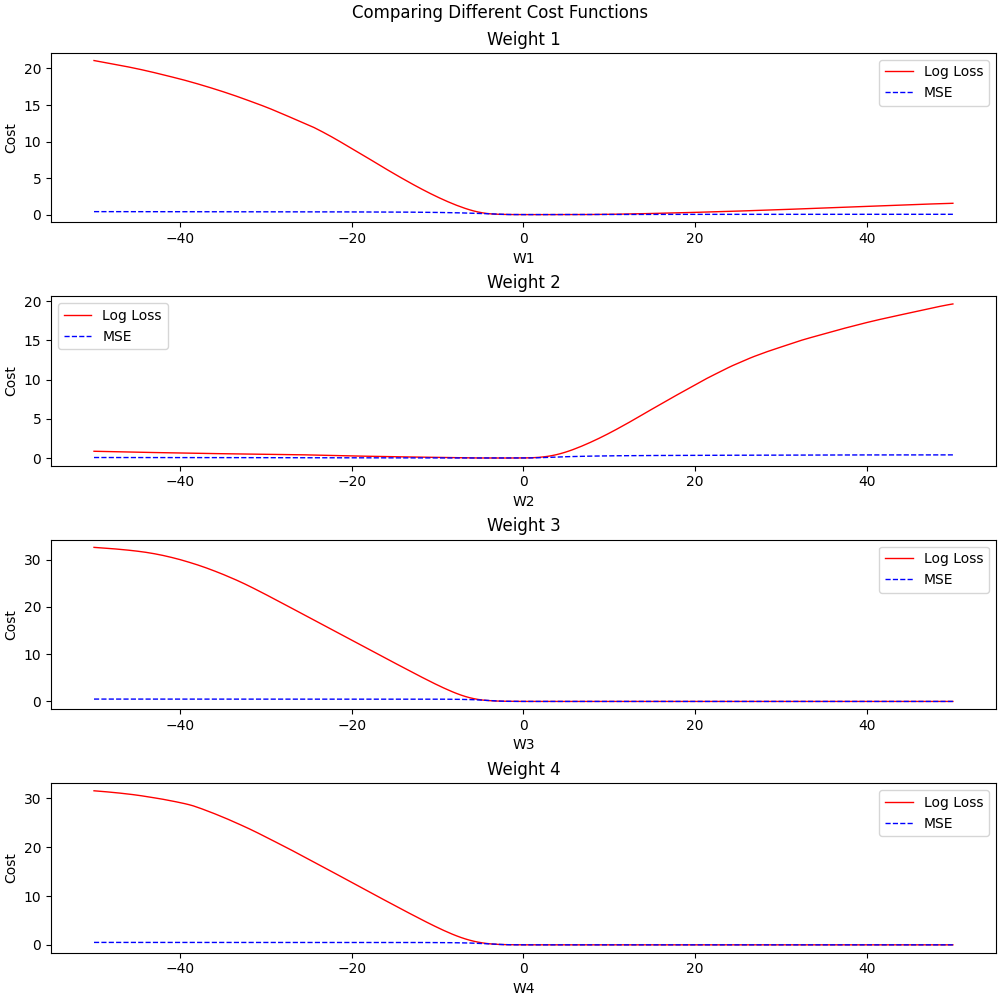

In [206]:
y_reshaped = target.reshape((-1,1))
samples = 200
frange = 50

fig, axes = plt.subplots(features,figsize=(10,10),layout="constrained")
fig.suptitle("Comparing Different Cost Functions")

for j in range(features):
    wrange = np.linspace(-frange, frange, samples)

    log_wjcosts = np.empty(samples)
    mse_wjcosts = np.empty(samples)
    
    for i in range(samples):
        log_weights_i = np.array(log_weights) # use weights we got from gradient descent
        log_weights_i[j,0] = wrange[i] # change jth feature weight and fix all other weights

        mse_weights_i = np.array(mse_weights)
        mse_weights_i[j,0] = wrange[i] # do same thing with mse        

        log_wjcosts[i] = log_loss_cost(log_weights_i,log_intercept,data,y_reshaped)
        mse_wjcosts[i] = mse_cost(mse_weights_i,mse_intercept,data,y_reshaped)

    axes[j].set_xlabel(f"W{j+1}")
    axes[j].set_ylabel("Cost")
    axes[j].set_title(f"Weight {j+1}")
    axes[j].plot(wrange, log_wjcosts, c='r',linewidth=1, label="Log Loss")
    axes[j].plot(wrange, mse_wjcosts, c='b',linewidth=1, linestyle='--',label="MSE")
    axes[j].legend()

Voila, look at these cost functions. They look a lot better than MSE ones. At least near the center, the lines look are more sloped than MSE curves. This will help the model learn a lot better and properly gradient descent. The scales are different here so it's better to look at the previous example lab and see the comparison like that. Next we should see the decision boundary and see how it looks like.